<a href="https://colab.research.google.com/github/blakeobeans/kaggle_notebooks/blob/master/Titanic_w_XGB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import matplotlib.pyplot as plt

### Mount Google Drive

In [2]:
from google.colab import drive
import os
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
#set wd
path = '/content/drive/My Drive/Colab Notebooks/Kaggle/Titanic'
os.chdir(path)
path

'/content/drive/My Drive/Colab Notebooks/Kaggle/Titanic'

In [0]:
from google.colab import files

### Set API Creds

In [0]:
import os
os.environ['KAGGLE_USERNAME'] = "blakeobeans"

In [0]:
os.environ['KAGGLE_KEY'] = "60017706bdc00c3f8b75bdd75f4331b0"

### Download Data

In [7]:
!kaggle competitions download -c titanic

test.csv: Skipping, found more recently modified local copy (use --force to force download)
train.csv: Skipping, found more recently modified local copy (use --force to force download)
gender_submission.csv: Skipping, found more recently modified local copy (use --force to force download)


### Import Data

In [0]:
import pandas as pd

In [0]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

## Exploratory Analysis

In [10]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [11]:
train.shape

(891, 12)

In [12]:
test.shape

(418, 11)

## Feature Engineering

#### Remove irrelevant variables

Removing 'PassengerID', 'Name', 'Ticket' and 'Cabin'.

In [0]:
train = train[['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']]
test = test[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']]

### Missing Data Imputation

In [0]:
import missingno as msno

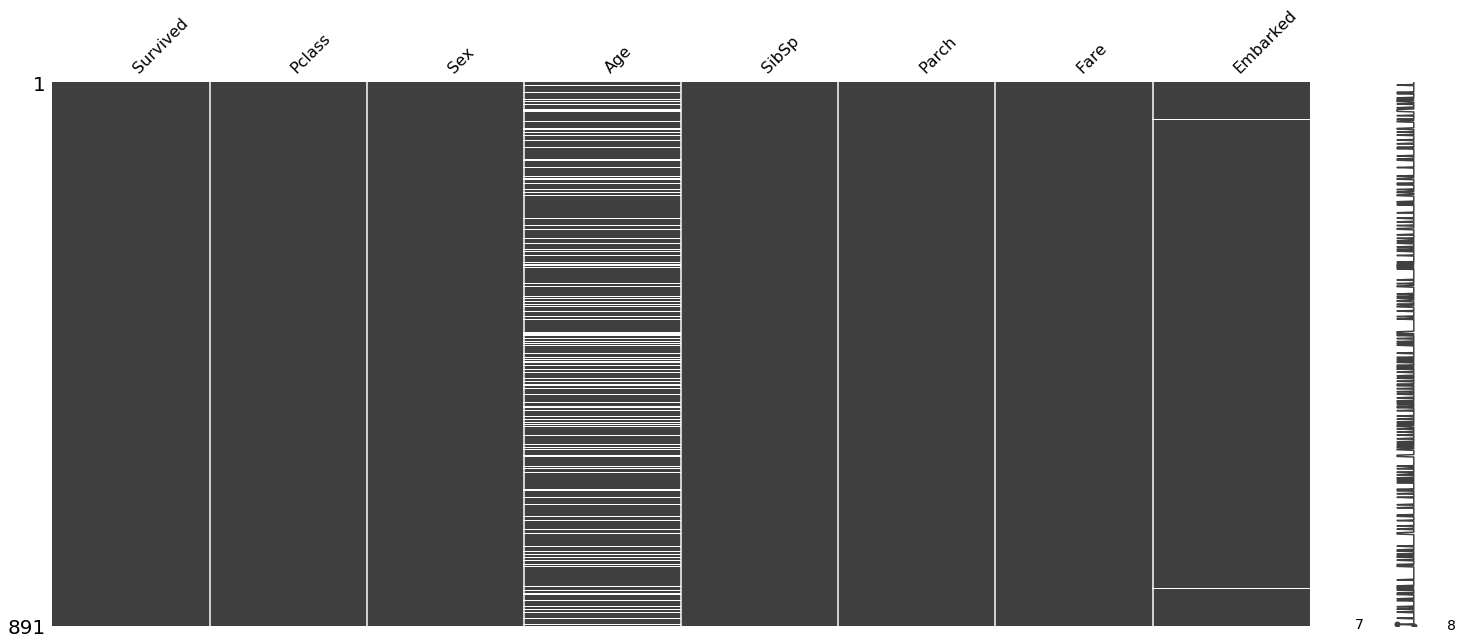

In [15]:
msno.matrix(train)

We're missing data for the "age" variable- one quantitative variable. We'll impute based on the most frequent value. This can be improved by looking at correlations between age and other variables in the dataset.

In [0]:
from sklearn import preprocessing
import numpy as np

In [0]:
#impute missing data for "Embarked"
from sklearn.impute import SimpleImputer
my_imputer = SimpleImputer(missing_values=np.NaN, strategy='most_frequent')

In [0]:
train_imputed = my_imputer.fit_transform(train)
test_imputed = my_imputer.fit_transform(test)

In [0]:
#convert imputed array into pandas df with column names
train_imputed = pd.DataFrame(train_imputed, columns = train.columns)
test_imputed = pd.DataFrame(test_imputed, columns = test.columns)

### Categorical Encoding

Because the XGBoost algorithm requires numeric value, we have to main options for dealing with categorical variables: **label encoding** and **one-hot encoding**.  
I'll opt for label encoding where there is an inherent rank and one-hot encoding otherwise.

In [20]:
train_imputed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
Survived    891 non-null object
Pclass      891 non-null object
Sex         891 non-null object
Age         891 non-null object
SibSp       891 non-null object
Parch       891 non-null object
Fare        891 non-null object
Embarked    891 non-null object
dtypes: object(8)
memory usage: 55.8+ KB


**Label encoding**: Pclass  
**One-hot encoding**: Sex, Embarked

In [0]:
train_imputed_cat_ohe = train_imputed[['Sex', 'Embarked']]
train_imputed_cat_le = train_imputed[['Pclass']]
train_imputed_quant = train_imputed[['Survived', 'Age', 'SibSp', 'Parch', 'Fare']]

In [0]:
test_imputed_cat_ohe = test_imputed[['Sex', 'Embarked']]
test_imputed_cat_le = test_imputed[['Pclass']]
test_imputed_quant = test_imputed[['Age', 'SibSp', 'Parch', 'Fare']]

#### Label Encoding

Label encoding can be done with pandas

In [23]:
train_imputed_cat_le.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 1 columns):
Pclass    891 non-null object
dtypes: object(1)
memory usage: 7.1+ KB


In [24]:
train_imputed_cat_le.head()

,Pclass
0,3
1,1
2,3
3,1
4,3


In [25]:
train_imputed_cat_le['Pclass'] = pd.to_numeric(train_imputed_cat_le['Pclass']) # Replace strings with an integer
test_imputed_cat_le['Pclass'] = pd.to_numeric(test_imputed_cat_le['Pclass']) # Replace strings with an integer

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


#### One-hot encoding

In [26]:
train_imputed_cat_ohe.Sex.unique()

array(['male', 'female'], dtype=object)

In [27]:
train_imputed_cat_ohe.Embarked.unique()

array(['S', 'C', 'Q'], dtype=object)

In [0]:
enc = preprocessing.OneHotEncoder()

In [0]:
enc.fit(train_imputed_cat_ohe)
onehotlabels = enc.transform(train_imputed_cat_ohe).toarray()
df = pd.DataFrame(onehotlabels)
train = pd.concat([train_imputed_quant, train_imputed_cat_le, df], axis=1, sort=False)

In [30]:
train.head()

,Survived,Age,SibSp,Parch,Fare,Pclass,0,1,2,3,4
0,0,22,1,0,7.25,3,0.0,1.0,0.0,0.0,1.0
1,1,38,1,0,71.2833,1,1.0,0.0,1.0,0.0,0.0
2,1,26,0,0,7.925,3,1.0,0.0,0.0,0.0,1.0
3,1,35,1,0,53.1,1,1.0,0.0,0.0,0.0,1.0
4,0,35,0,0,8.05,3,0.0,1.0,0.0,0.0,1.0


In [0]:
train.columns = ['Survived', 'Age', 'SibSp', 'Parch', 'Fare', 'Pclass', 'M', 'F', 'S', 'C', 'Q']

In [0]:
enc.fit(test_imputed_cat_ohe)
onehotlabels = enc.transform(test_imputed_cat_ohe).toarray()
df = pd.DataFrame(onehotlabels)
test = pd.concat([test_imputed_quant, test_imputed_cat_le, df], axis=1, sort=False)

In [0]:
test.columns = ['Age', 'SibSp', 'Parch', 'Fare', 'Pclass', 'M', 'F', 'S', 'C', 'Q']

## Create Validation Dataset

Because this is a public dataset, the test data can be submitted multiple times. Therefore, a validation dataset is not necessary.

In [0]:
from sklearn.model_selection import train_test_split
train, val = train_test_split(train, test_size=0.1, random_state=42)

In [0]:
train_label = train['Survived']
val_label = val['Survived']

In [0]:
train_features = train.drop('Survived', axis = 1)
val_features = val.drop('Survived', axis = 1)

In [0]:
train[['Survived', 'Age', 'SibSp', 'Parch', 'Fare']] = train[['Survived', 'Age', 'SibSp', 'Parch', 'Fare']].astype(float)
val[['Survived', 'Age', 'SibSp', 'Parch', 'Fare']] = val[['Survived', 'Age', 'SibSp', 'Parch', 'Fare']].astype(float)

In [0]:
test[['Age', 'SibSp', 'Parch', 'Fare']] = test[['Age', 'SibSp', 'Parch', 'Fare']].astype(float)

In [0]:
train_features[['Age', 'SibSp', 'Parch', 'Fare']] = train_features[['Age', 'SibSp', 'Parch', 'Fare']].astype(float)
val_features[['Age', 'SibSp', 'Parch', 'Fare']] = val_features[['Age', 'SibSp', 'Parch', 'Fare']].astype(float)
#val_features.dtypes

In [0]:
train_label = train_label.astype(float)
val_label = val_label.astype(float)

## XGBoost

I'll be using only one model- XGBoost.

### Creating Dataset

In [0]:
import xgboost as xgb

In [42]:
dtrain = xgb.DMatrix(train_features, label=train_label)
dval = xgb.DMatrix(val_features, label=val_label)
dtest = xgb.DMatrix(test)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


### Grid Search w/ Cross Validation

In [0]:
cv_params = {
     'colsample_bytree': np.linspace(0.5, 0.9, 5), #fraction of features to use
     'n_estimators':[100, 200, 1000],
     'max_depth': [10, 15, 20, 25], #number of allowable nodes
     'min_child_weight': [1,3,5], #weight required for new node
     'learning_rate': [0.1, 0.5]
}

In [0]:
ind_params = {'seed':0, 
              'subsample': 0.8, #fraction of rows to subsample
              'objective': 'binary:logistic'}

In [0]:
from sklearn.model_selection import GridSearchCV

In [0]:
optimized_GBM = GridSearchCV(xgb.XGBClassifier(**ind_params), 
                             cv_params, 
                             scoring = 'accuracy', 
                             cv = 5, 
                             n_jobs = -1, 
                             verbose = 1)

In [127]:
optimized_GBM.fit(train_features, 
                  train_label,
                  eval_set = [(val_features, val_label)],
                  eval_metric = "error")

Fitting 5 folds for each of 360 candidates, totalling 1800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   18.0s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 1796 tasks      | elapsed: 11.4min


[0]	validation_0-error:0.188889
[1]	validation_0-error:0.177778
[2]	validation_0-error:0.188889
[3]	validation_0-error:0.177778
[4]	validation_0-error:0.177778
[5]	validation_0-error:0.177778
[6]	validation_0-error:0.188889
[7]	validation_0-error:0.2
[8]	validation_0-error:0.2
[9]	validation_0-error:0.2
[10]	validation_0-error:0.188889
[11]	validation_0-error:0.188889
[12]	validation_0-error:0.166667
[13]	validation_0-error:0.155556
[14]	validation_0-error:0.166667
[15]	validation_0-error:0.166667
[16]	validation_0-error:0.166667
[17]	validation_0-error:0.177778
[18]	validation_0-error:0.166667
[19]	validation_0-error:0.166667
[20]	validation_0-error:0.177778
[21]	validation_0-error:0.177778
[22]	validation_0-error:0.166667
[23]	validation_0-error:0.166667
[24]	validation_0-error:0.177778
[25]	validation_0-error:0.188889
[26]	validation_0-error:0.188889
[27]	validation_0-error:0.177778
[28]	validation_0-error:0.188889
[29]	validation_0-error:0.166667
[30]	validation_0-error:0.177778
[3

[Parallel(n_jobs=-1)]: Done 1800 out of 1800 | elapsed: 11.4min finished


[69]	validation_0-error:0.166667
[70]	validation_0-error:0.166667
[71]	validation_0-error:0.155556
[72]	validation_0-error:0.155556
[73]	validation_0-error:0.166667
[74]	validation_0-error:0.166667
[75]	validation_0-error:0.166667
[76]	validation_0-error:0.155556
[77]	validation_0-error:0.166667
[78]	validation_0-error:0.166667
[79]	validation_0-error:0.166667
[80]	validation_0-error:0.166667
[81]	validation_0-error:0.166667
[82]	validation_0-error:0.166667
[83]	validation_0-error:0.166667
[84]	validation_0-error:0.166667
[85]	validation_0-error:0.155556
[86]	validation_0-error:0.166667
[87]	validation_0-error:0.155556
[88]	validation_0-error:0.166667
[89]	validation_0-error:0.166667
[90]	validation_0-error:0.166667
[91]	validation_0-error:0.166667
[92]	validation_0-error:0.166667
[93]	validation_0-error:0.166667
[94]	validation_0-error:0.166667
[95]	validation_0-error:0.155556
[96]	validation_0-error:0.155556
[97]	validation_0-error:0.155556
[98]	validation_0-error:0.155556
[99]	valid

GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=0, silent=None,
                                     subsample=0.8, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'colsample_bytree': array([0.5, 0.6, 0.7, 0.8, 0.9]),
                         'learning_rate': [0.1, 0.5],
                         'max_depth': [10, 15, 

### Reviewing Grid Scores

In [128]:
pd.DataFrame(optimized_GBM.cv_results_['params']).head()

,colsample_bytree,learning_rate,max_depth,min_child_weight,n_estimators
0,0.5,0.1,10,1,100
1,0.5,0.1,10,1,200
2,0.5,0.1,10,1,1000
3,0.5,0.1,10,3,100
4,0.5,0.1,10,3,200


### Tuning Hyperparameters

In [106]:
cv_params

{'colsample_bytree': array([0.5, 0.6, 0.7, 0.8, 0.9]),
 'learning_rate': [0.1, 0.5],
 'max_depth': [10, 15, 20, 25],
 'min_child_weight': [1, 3, 5],
 'n_estimators': [100, 200, 1000]}

In [0]:
#adjust all downward
cv_params_2 =  {
     'colsample_bytree': np.linspace(0.4, 0.5),
     'n_estimators':[50, 100],
     'max_depth': [5, 10],
     'min_child_weight': [0.5, 1],
     'learning_rate': [0.05, 0.1]
     }

In [0]:
optimized_GBM_2 = GridSearchCV(xgb.XGBClassifier(**ind_params), 
                             cv_params_2, 
                             scoring = 'accuracy', 
                             cv = 5, #adjusted downward
                             n_jobs = -1, 
                             verbose = 1)

In [131]:
optimized_GBM_2.fit(train_features, 
                    train_label,
                    eval_set = [(val_features, val_label)],
                    eval_metric = "error")

Fitting 5 folds for each of 800 candidates, totalling 4000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 388 tasks      | elapsed:   27.0s
[Parallel(n_jobs=-1)]: Done 888 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 1588 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 2488 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 3588 tasks      | elapsed:  4.1min


[0]	validation_0-error:0.2
[1]	validation_0-error:0.166667
[2]	validation_0-error:0.155556
[3]	validation_0-error:0.177778
[4]	validation_0-error:0.177778
[5]	validation_0-error:0.177778
[6]	validation_0-error:0.177778
[7]	validation_0-error:0.177778
[8]	validation_0-error:0.166667
[9]	validation_0-error:0.2
[10]	validation_0-error:0.188889
[11]	validation_0-error:0.177778
[12]	validation_0-error:0.177778
[13]	validation_0-error:0.177778
[14]	validation_0-error:0.177778
[15]	validation_0-error:0.188889
[16]	validation_0-error:0.188889
[17]	validation_0-error:0.188889
[18]	validation_0-error:0.188889
[19]	validation_0-error:0.188889
[20]	validation_0-error:0.188889
[21]	validation_0-error:0.188889
[22]	validation_0-error:0.188889
[23]	validation_0-error:0.188889
[24]	validation_0-error:0.188889
[25]	validation_0-error:0.188889
[26]	validation_0-error:0.188889
[27]	validation_0-error:0.188889
[28]	validation_0-error:0.2
[29]	validation_0-error:0.2
[30]	validation_0-error:0.2
[31]	validat

[Parallel(n_jobs=-1)]: Done 4000 out of 4000 | elapsed:  4.6min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_po...
       0.46122449, 0.46326531, 0.46530612, 0.46734694, 0.46938776,
       0.47142857, 0.47346939, 0.4755102 , 0.47755102, 0.47959184,
       0.48163265, 0.48367347, 0.48571429, 0.4877551 , 0.48979592,
       0.49183673, 0.49387755, 0.49591837, 0.49795918, 0.5       ]),
                         'learning_rate': [0.05

In [132]:
pd.DataFrame(optimized_GBM_2.cv_results_['params']).head()

,colsample_bytree,learning_rate,max_depth,min_child_weight,n_estimators
0,0.4,0.05,5,0.5,50
1,0.4,0.05,5,0.5,100
2,0.4,0.05,5,1.0,50
3,0.4,0.05,5,1.0,100
4,0.4,0.05,10,0.5,50


### Picking Best Parameters

In [0]:
params = optimized_GBM_2.best_params_

In [0]:
params['seed'] = 0
params['subsample'] = 0.8
params['objective'] = 'binary:logistic'  

## Early Stopping CV

In [0]:
cv_xgb = xgb.cv(params = params, 
                dtrain = dtrain, 
                num_boost_round = 3000, #number of trees to build
                nfold = 5,
                metrics = ['error'], 
                early_stopping_rounds = 100) # Look for early stopping that minimizes error

In [161]:
cv_xgb.tail()

,train-error-mean,train-error-std,test-error-mean,test-error-std
89,0.058361,0.007722,0.169752,0.021088
90,0.058049,0.007187,0.169752,0.021088
91,0.056800,0.007133,0.169752,0.021088
92,0.056800,0.007723,0.170994,0.022868
93,0.056800,0.007133,0.168494,0.023647


90.5% accuracy, set # rounds to 198

### Training Model

In [163]:
bst = xgb.train(params, 
                dtrain, 
                evals = [(dval, "Validation")],
                early_stopping_rounds = 10, #this has an effect
                num_boost_round = 93)

[0]	Validation-error:0.2
Will train until Validation-error hasn't improved in 10 rounds.
[1]	Validation-error:0.166667
[2]	Validation-error:0.155556
[3]	Validation-error:0.177778
[4]	Validation-error:0.177778
[5]	Validation-error:0.177778
[6]	Validation-error:0.177778
[7]	Validation-error:0.177778
[8]	Validation-error:0.166667
[9]	Validation-error:0.2
[10]	Validation-error:0.188889
[11]	Validation-error:0.177778
[12]	Validation-error:0.177778
Stopping. Best iteration:
[2]	Validation-error:0.155556



### Analyze Model

In [0]:
#xgb.plot_importance(bst)

In [0]:
#xgb.to_graphviz(bst, num_trees=2)

## Analyze Performance on Final Test Data

Not necessary here because this is a public contest with unlimited submissions.

## Making Predictions

In [0]:
y_pred = bst.predict(dtest)

In [165]:
y_pred.shape

(418,)

In [0]:
y_pred = np.where(y_pred > 0.5, 1, 0)
y_pred = np.asarray(y_pred)

In [0]:
test = pd.read_csv('test.csv')

In [0]:
submission = pd.DataFrame(
    {"PassengerID": test.iloc[:,0],
     "Survived": y_pred}
)

In [169]:
submission.head()

,PassengerID,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [0]:
from numpy import asarray
from numpy import savetxt
savetxt('submission_11.csv', submission, delimiter=',') # save to csv file
submission.to_csv("submission_11.csv", index = False)

## Submitting via Kaggle API

In [171]:
!kaggle competitions submit -c titanic -f submission_11.csv -m 'added parameter tuning'

100% 2.77k/2.77k [00:03<00:00, 868B/s]
Successfully submitted to Titanic: Machine Learning from Disaster

In [172]:
!kaggle competitions submissions -c titanic

fileName           date                 description                                      status    publicScore  privateScore  
-----------------  -------------------  -----------------------------------------------  --------  -----------  ------------  
submission_11.csv  2020-03-11 23:30:08  added parameter tuning                           complete  0.79425      None          
submission_11.csv  2020-03-11 23:26:22  added parameter tuning                           complete  0.78947      None          
submission_11.csv  2020-03-11 23:24:49  added parameter tuning                           complete  0.78947      None          
submission_10.csv  2020-03-11 22:27:29  Changed y_pred                                   complete  0.00000      None          
submission_09.csv  2020-03-11 22:26:04  Added cross-validation, changed boosting rounds  complete  0.78947      None          
submission_08.csv  2020-03-11 19:23:58  Added cross-validation, changed boosting rounds  complete  0.78947     